In [93]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt


def write_image(img, image_name):
	cv2.imwrite(image_name + '.png',img)
    
    
def add_padding(image, padding_width, background_value):

	h, w = image.shape

	_padded_img = [[background_value for col in range(w + (padding_width*2))] for row in range(h + (padding_width*2))]

	for i in range(h):
		for j in range(w):
			_padded_img[i + padding_width][j + padding_width] = image[i][j]


	return np.asarray(_padded_img)



def remove_padding(image, padding_width):

	h, w = image.shape

	_no_padded_img = [[0 for col in range(w - (padding_width*2))] for row in range(h - (padding_width*2))]

	for i in range(padding_width, h-padding_width):
		for j in range(padding_width, w-padding_width):
			_no_padded_img[i - padding_width][j - padding_width] = image[i][j]


	return np.asarray(_no_padded_img)





def convolve_img(img, kernel,kernel_radius):

    padded_img = add_padding(image = img, padding_width = kernel_radius, background_value = background_value)

    height, width = img.shape
    output_image = [[0 for col in range(width)] for row in range(height)]


    for i in range(kernel_radius, height-kernel_radius):
        for j in range(kernel_radius, width-kernel_radius):

            # elementwise multiplication sum

            loop_end = (kernel_radius*2)+1

            sum = 0
            for x in range(0,loop_end):
                for y in range(0,loop_end):
                    sum += kernel[x][y] * padded_img[i-kernel_radius+x][j-kernel_radius+y]

            output_image[i][j] = sum


    remove_padding(image = np.asarray(output_image), padding_width = kernel_radius)
    return np.asarray(output_image)


def gaussian(x, mu, sigma):
    return math.exp( -(((x-mu)/(sigma))**2)/2.0 )


def get_gaussian_kernel(sigma):

    kernel_radius = 5

    # compute the actual kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]


    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]

    return kernel2d


def edge_detection_x(img, threshold):

    x_kernel = [
                [-1, -2, -1], 
                [0, 0, 0], 
                [1, 2 , 1] 
                ]  

    edge_x_img = convolve_img(img,x_kernel,1)

    # print_image(edge_x_img,'x edge')
    h,w = edge_x_img.shape

    max_val = 0
    for i in range(0,h):
        for j in range(1,w):
            edge_x_img[i][j] = abs(edge_x_img[i][j])
            max_val = max(max_val,edge_x_img[i][j])

    pos_edge_x = [[0.0 for col in range(w)] for row in range(h)]
    print(max_val)

    for i in range(0,h):
        for j in range(1,w):
            k = (edge_x_img[i][j]/max_val)*255
            if k>threshold:
                pos_edge_x[i][j] = 255
            else:
                pos_edge_x[i][j] = 0
            


    
    pos_edge_x = np.asarray(pos_edge_x)
    return pos_edge_x



def cast_vote(accumulator, x, y, radius):

    # value of b needs to cycled throughout the imag size and get the correspondent value of a
    # (x-a)^2 + (y-b)^2 = r^2
    # a = abs(x - sqrt((y-b)^2 - r^2))

    rw,cl = accumulator.shape 
    
    for radius in range(17,23):

        for theta in range(360):

            theta_rad = math.radians(theta)

            a = int(round(x - (radius*math.cos(theta_rad))))

            b = int(round(y + (radius*math.sin(theta_rad))))

            if (a<cl and a>-1) and (b<rw and b>-1):
                accumulator[b][a] +=1



    return accumulator


def mark_lines(a, b, img, radius):
    
    #(x-a)^2 + (y-b)^2 = r^2
    h, w, _ = img.shape
    
#     for y in range(h):

#         x = int(round(a + math.sqrt(abs(radius**2 - (y-b)**2))))
#         if x<w and x> -1:
#             img[y][x] = [0,255,0]
            
            
            
    for radius in range(17,23):
        for angle in range(0, 360):
            x = int(round(radius * math.sin(math.radians(angle)) + a))
            y = int(round(radius * math.cos(math.radians(angle)) + b))

            if (x<w and x> -1) and (y<h and y> -1):
                img[y][x] = [0,255,0]           

    return img




# main

In [101]:
background_value = 220

In [102]:

hough_img = cv2.imread("original_imgs/hough.jpg", 0)

simg = hough_img.copy()
simg = convolve_img(hough_img, get_gaussian_kernel(math.sqrt(2)),3)

In [131]:
# xedge = edge_detection_x(simg, threshold =50)
xedge = edge_detection_x(simg, threshold =16)

880.0


In [132]:




# simg = convolve_img(hough_img, get_gaussian_kernel(math.sqrt(2)),3)
# simg = edge_detection_x(hough_img)
# xedge = convolve_img(simg, get_gaussian_kernel(math.sqrt(2)),3)


# edge = cv2.Canny(hough_img,100,200)
# xedge = convolve_img(edge, get_gaussian_kernel(math.sqrt(2)),3)

write_image(xedge,'output/filtered')

r = 20

h, w = hough_img.shape


accumulator = np.zeros(hough_img.shape)

In [133]:

for i in range(h):
    for j in range(w):
        if xedge[i][j] !=0:
            
            accumulator = cast_vote(accumulator, y=i, x=j, radius = r)


write_image(accumulator,'output/accumulator')

In [134]:
hough_img_col = cv2.imread("original_imgs/hough.jpg")
cirles = hough_img_col.copy()


co_p_t = np.unravel_index(np.argsort(accumulator.ravel())[-2500:], accumulator.shape)
# print(co_p_t)

for z in range(len(co_p_t[0])):
    b = co_p_t[0][z]
    a = co_p_t[1][z]
    
    cirles = mark_lines(a, b, cirles, r)


write_image(cirles,'output/cirles')




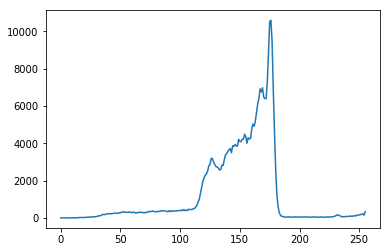

In [90]:
# find frequency of pixels in range 0-255 
histr = cv2.calcHist([simg],[0],None,[256],[0,256]) 
  
# show the plotting graph of an image 
plt.plot(histr) 
plt.show() 